# AZlyrics, webscraping and nlp academic project 
---
*Autors:*

 - [Paul Leydier](https://github.com/pleydier) 
 
 - [Wenceslas Sanchez](https://github.com/Orlogskapten)
 
 
Our goal is to scrap artist lyrics on [https://search.azlyrics.com](https://search.azlyrics.com) and to analyse them.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from random_user_agent.user_agent import UserAgent
from random_user_agent.params import SoftwareName, OperatingSystem
import warnings
import unidecode
import requests
from bs4 import BeautifulSoup
import urllib
import urllib.request
from lxml import html
import sys
from random import random

from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
import jellyfish
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

sns.set()

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paull\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# I. WebScraping

## 1.1. First step webscraping

We are going to build a dataset, which is going to contain artist names, albums names, musics names, production years, and url to connect to the lyrics webpage.

In [3]:
def artist_to_url(artist):
    """ With an artist name, it generates an URL to `https://www.azlyrics.com`. 
        
    We observed a pattern in the URL generation. If the first caracter in artist name is a letter
    then URL should be :
        https://www.azlyrics.com/{first artist name letter}/{artist name}
    else:
        https://www.azlyrics.com/19/{artist name}
   
    Args:
        -artist: the artist name
    
    Output:
        >>> artist_to_url("Schoolboy Q")
        >>> https://www.azlyrics.com/s/schoolboyq.html'
    
    Raises:
        None
        
    """
    url_base= """https://www.azlyrics.com"""
    name= re.sub(' ','',artist)
    # Remove accents like é or à
    name= unidecode.unidecode(name.lower())
    first_l= list(name)[0]
    # Some artist name start with a number
    # and so it generates an URL otherwise
    if first_l.isalpha():
        url= """{}/{}/{}.html""".format(url_base, first_l, name)
    else:
        url= """{}/19/{}.html""".format(url_base, name)
    return url

In [4]:
#test
artist_to_url("Schoolboy Q")

'https://www.azlyrics.com/s/schoolboyq.html'

In [5]:
def transform_proxy_http(proxy):
    """ From a proxy (with his port), we generate an http connexion adress
        
    Args:
        -proxy
        
    Output:
        >>> transform_proxy_http("91.228.8.162:8080")
        >>> "http://91.228.8.162:8080"
        
    Raises:
        None
        
    """
    return "http://"+proxy

In [6]:
# We wollect a daily proxy list
urll= "https://raw.githubusercontent.com/clarketm/proxy-list/master/proxy-list-raw.txt"
urllib.request.urlretrieve(urll, 'data/proxy_list.txt')

listed_proxy= []
f= open("data/proxy_list.txt", "r")
listed_proxy= f.read().split("\n")

In [ ]:
#
# NE PAS EXECUTER SI ON VEUT GAGNER DU TEMPS
good_prox= []
# Pour raison de simpliciter, on cherche que les proxy qui ont un port 8080
pat= re.compile('.:8080$')

proxies_list= [l for l in listed_proxy \
               if l in list(filter(pat.findall, listed_proxy))]

for prox in proxies_list:
    # On cherche 20 proxy de bonnes qualités
    if len(good_prox) <= 20:
        try:
            print(prox)
            
            #On génère un User Agent aléatoire pour chaque proxy
            software_names = [SoftwareName.CHROME.value]
            operating_systems = [OperatingSystem.WINDOWS.value, OperatingSystem.LINUX.value]
            user_agent_rotator = UserAgent(software_names=software_names,
                           operating_systems=operating_systems, limit=100)
            
            proxies= {"http":transform_proxy_http(prox),
                    "https":transform_proxy_http(prox)}

            user_agent = user_agent_rotator.get_random_user_agent()
            headers= {"User-Agent":user_agent}

            r = requests.Session()
            r.headers.update(headers)
            r.proxies.update(proxies)

            # Connexion à la page
            page= r.get("https://www.azlyrics.com/", proxies= proxies, headers= headers)

            # Si la connexion est fructueuse, alors le proxy est stocké
            good_prox.append(prox)
        except:
            # Si je ne peux pas me connecter avec ce proxy, alors je teste le suivant
            print("Not Good")
            continue
    else:
        # Si j'ai 20 bon proxy, j'arrète la sélection
        break
print("Fin")

good_prox[:5]

In [7]:
def album_url_year(artist, proxies_list= None, user_agent= True):
    """ Allows us to generate, for an artist, a dataframe with information about his artistic
        productions.
        
    Starting with a artist name, our function collect albums from that artist, and associate an
    production year, and all music's names.
    The user can either choose to use proxy or not. But if an proxiy list is provided, then the
    computing time will incredibly increase.
    
    Args:
        -artist: artist name
        -proxies_list: default value None. Its a list of proxies the user want to add, to make
            his scraping task easier, but time consuming.
        -user_agent: default value True. The user can choose to generate a random user agent.
        
    Output:
        >>> album_url_year("jinjer")
        >>> 	Artiste	Annee	Album	Url
            0	jinjer	2012	Inhale. Do Not Breathe	https://www.azlyrics.com/lyrics/jinjer/untilth...
            1	jinjer	2012	Inhale. Do Not Breathe	https://www.azlyrics.com/lyrics/jinjer/waltz.html
            2	jinjer	2012	Inhale. Do Not Breathe	https://www.azlyrics.com/lyrics/jinjer/scissor...
            3	jinjer	2012	Inhale. Do Not Breathe	https://www.azlyrics.com/lyrics/jinjer/exposed...
            4	jinjer	2012	Inhale. Do Not Breathe	https://www.azlyrics.com/lyrics/jinjer/mylostc...
            5	jinjer	2014	Cloud Factory     	    https://www.azlyrics.com/lyrics/jinjer/outland...
            6	jinjer	2014	Cloud Factory    	    https://www.azlyrics.com/lyrics/jinjer/aplusor...
    
    Raises:
        -warning if we can't built our dataframev (check the list lengths)
        -warning if we can't get the artist (artist not in the website, wrong URL pattern, too
            much error with proxy using)
        -warning if the proxy can't help us to connect
        
    """
    
    year, album_name, url_song= [], [], []
    
    if user_agent:
        software_names = [SoftwareName.CHROME.value]
        operating_systems = [OperatingSystem.WINDOWS.value, OperatingSystem.LINUX.value]
        user_agent_rotator = UserAgent(software_names= software_names,
                                   operating_systems= operating_systems, limit= 100)
        
        user_agent = user_agent_rotator.get_random_user_agent()
        headers= {"User-Agent":user_agent}
        
        r = requests.Session()
        r.headers.update(headers)
    
    else:
        r = requests.Session()
        headers= None
        
    if proxies_list:
        
        random_proxy= sorted(proxies_list, key=lambda x: random())
        i = 0
        for prox in random_proxy:
            if i < 5: #s if too many failed
                i += 1
                try:

                    proxies= {"http":transform_proxy_http(prox),
                            "https":transform_proxy_http(prox)}

                    r.proxies.update(proxies)

                    page= r.get(artist_to_url(artist), proxies= proxies, headers= headers)

                    soup= BeautifulSoup(page.text, 'html.parser')
                    html_page= soup.find('div', id= 'listAlbum')

                    html_data= str(html_page).split('<div class="album"')[1:][:-1]
                    for ht in html_data:
                    # we definie regex pattern to get album name from html page, with years, and
                        # lyrics URL
                        pattern_yr= re.compile('</b> \((\d{4})\)</div>|</b> \((\d{4})\)<br/>')
                        pattern_alb= re.compile('<b>"([\s\S]*)"</b>')
                        pattern_url= re.compile('href="..([\s\S]*).html" target=')

                        year.append(pattern_yr.search(ht).group(1))
                        album_name.append(pattern_alb.search(ht).group(1))
                        
                        url_list= ht.split('\n')
                        url_base= "https://www.azlyrics.com"
                        url_song.append([url_base + pattern_url.search(href).group(1) + ".html" \
                                for href in url_list \
                                if pattern_url.search(href) != None])
                    try:
                        df= pd.DataFrame(
                        {
                            "Artiste": [artist]*len(year),
                            "Annee": year,
                            "Album": album_name,
                            "Url": url_song
                        })
                    except:
                        warnings.warn("Attention, il y a un problème dans la construction du DataFrame")
                        return None
                    
                    # the dataframe we generated contain a list of url
                    # we want 1 line per url
                    df_not_listed= pd.DataFrame({
                      col:np.repeat(df[col].values, df["Url"].str.len())
                      for col in df.columns.drop("Url")
                    }
                    ).assign(**{
                        "Url":np.concatenate(df["Url"].values)
                    })[df.columns]

                    return df_not_listed
                except:
                    warnings.warn("Attention, le proxy {} n'a pas permis de vous connecter à \
                                  la page souhaitée".format(prox))
                    continue
            else:
                break
                
        warnings.warn("Attention, l'artiste {} n'a pas été trouvé".format(artist))
        return None
    
    else:
        
        page= r.get(artist_to_url(artist))
        soup= BeautifulSoup(page.text, 'html.parser')
        html_page= soup.find('div', id= 'listAlbum')
        
        try: # try to connect
            html_data= str(html_page).split('<div class="album"')[1:][:-1]
            for ht in html_data:
                # we definie regex pattern to get album name from html page, with years, and
                # lyrics URL                
                pattern_yr= re.compile('</b> \((\d{4})\)</div>|</b> \((\d{4})\)<br/>')
                pattern_alb= re.compile('<b>"([\s\S]*)"</b>')
                pattern_url= re.compile('href="..([\s\S]*).html" target=')

                year.append(pattern_yr.search(ht).group(1))
                album_name.append(pattern_alb.search(ht).group(1))
                
                url_list= ht.split('\n')
                url_base= "https://www.azlyrics.com"
                url_song.append([url_base + pattern_url.search(href).group(1) + ".html" \
                        for href in url_list \
                        if pattern_url.search(href) != None])
            try: # built the end dataframe
                df= pd.DataFrame(
                {
                    "Artiste": [artist]*len(year),
                    "Annee": year,
                    "Album": album_name,
                    "Url": url_song
                })
                
            except: 
                warnings.warn("Attention, il y a un problème dans la construction du DataFrame")
                return None

            # the dataframe we generated contain a list of url
            # we want 1 line per url
            df_not_listed= pd.DataFrame({
              col:np.repeat(df[col].values, df["Url"].str.len())
              for col in df.columns.drop("Url")
            }
            ).assign(**{
                "Url":np.concatenate(df["Url"].values)
            })[df.columns]

            return df_not_listed
        
        except:
            warnings.warn("Attention, l'artiste {} n'a pas été trouvé".format(artist))
            return None

In [8]:
album_url_year("jinjer", user_agent= False)

,Artiste,Annee,Album,Url
0,jinjer,2012,Inhale. Do Not Breathe,https://www.azlyrics.com/lyrics/jinjer/untilth...
1,jinjer,2012,Inhale. Do Not Breathe,https://www.azlyrics.com/lyrics/jinjer/waltz.html
2,jinjer,2012,Inhale. Do Not Breathe,https://www.azlyrics.com/lyrics/jinjer/scissor...
3,jinjer,2012,Inhale. Do Not Breathe,https://www.azlyrics.com/lyrics/jinjer/exposed...
4,jinjer,2012,Inhale. Do Not Breathe,https://www.azlyrics.com/lyrics/jinjer/mylostc...
5,jinjer,2014,Cloud Factory,https://www.azlyrics.com/lyrics/jinjer/outland...
6,jinjer,2014,Cloud Factory,https://www.azlyrics.com/lyrics/jinjer/aplusor...
7,jinjer,2014,Cloud Factory,https://www.azlyrics.com/lyrics/jinjer/nohoard...
8,jinjer,2014,Cloud Factory,https://www.azlyrics.com/lyrics/jinjer/cloudfa...
9,jinjer,2014,Cloud Factory,https://www.azlyrics.com/lyrics/jinjer/whoisgo...


In [9]:
artiste_name_style = {
    "Slipknot":"rock",
    "DREAMERS":"rock",
    "Bring Me The Horizon":"rock",
    "Motionless in White":"rock",
    "Falling In Reverse":"rock",
    "Eminem":"rap",
    "Justin Bieber":"pop",
    "Post Malone":"rap",
    "Billie Eilish":"pop",
    "Mac Miller":"rap",
}

artist_name= [name for name in artiste_name_style.keys()]

artist_random= sorted(artist_name, key=lambda x: random())
df= pd.DataFrame()
for art in artist_random:
    print("\n"+art)
    df= pd.concat([album_url_year(art), df], ignore_index= True)

print("\nFin")


Falling In Reverse

Billie Eilish

Bring Me The Horizon

Post Malone

Motionless in White

DREAMERS

Justin Bieber

Slipknot

Eminem

Mac Miller

Fin


In [10]:
#ajout colonne Style à partir du dictionnaire
df["Style"]= df["Artiste"].map(artiste_name_style)
df.head()

,Artiste,Annee,Album,Url,Style
0,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/intr...,rap
1,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/soun...,rap
2,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/barz...,rap
3,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/pahu...,rap
4,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/what...,rap


In [11]:
def verification(df):
    print("Vérifier si des valeurs sont None")
    for col in df.columns:
        nul= (df[col].isnull()).sum()
        sh= df.shape[0]
        print("\n")
        print(col)
        print(nul)
        print("Soit: {}% de valeurs None".format((nul/sh)*100))
    pass

In [12]:
verification(df)

Vérifier si des valeurs sont None


Artiste
0
Soit: 0.0% de valeurs None


Annee
0
Soit: 0.0% de valeurs None


Album
0
Soit: 0.0% de valeurs None


Url
0
Soit: 0.0% de valeurs None


Style
0
Soit: 0.0% de valeurs None


In [13]:
df.shape

(1064, 5)

In [14]:
# in case, we saved the actual dataset
export_df= df.to_csv("data/dataset_url_lyrics.csv", index= False, header= True)

## 1.2. Get lyrics from URL

In [15]:
df= pd.read_csv('data/dataset_url_lyrics.csv')
print(df.shape)
df.head()

(1064, 5)


,Artiste,Annee,Album,Url,Style
0,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/intr...,rap
1,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/soun...,rap
2,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/barz...,rap
3,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/pahu...,rap
4,Mac Miller,2009,The Jukebox: Prelude To Class Clown,https://www.azlyrics.com/lyrics/macmiller/what...,rap


In [16]:
def pretransformation_lyric(url_son, proxies_list= None, user_agent= True):
    """ Get url web page content
    
    Args:
        -url_son: url which contains the lyrics 
        -proxies_list: default value None. Its a list of proxies the user want to add, to make
            his scraping task easier, but time consuming.
        -user_agent: default value True. The user can choose to generate a random user agent.
    
    Output: 
        >>> pretransformation_lyric("https://www.azlyrics.com/lyrics/jinjer/ape.html")
        >>> 'The beginning of all beginnings The era of nonexistence When the Earth wasnt 
            the Earth When our planet was a fireball It was raining heavily for a thousand 
            years And the fireball became an ocean That cooking water the primal soup A natural 
            lifegiving potion  This substance strove to find a way To create another form of 
            miracle  I brought a myriad atoms and turn them into your flesh Regenerated 
            through destruction and chaos While the young world was sculpting itself No one 
            could notice how you stroke a different pose  Voracious ape who walks upright 
            Who deserts life to satisfy his appetite Dont you remember you were the size 
            of a bean Now what a shame to wear the name of a human being  Oh here you are 
            Vertically standing He who calls himself intelligent But has not much for understanding
            Oh here you go Mr Knowitall I made a mistake when I created you long time ago  
            Oh here you go Oh here you go Oh here you go  Just the mention of your name Would 
            make the whole world start to shake Who gave you right to save your life By taking 
            life from others By taking life away  By taking life away By taking life away  
            Bloodthirsty ape who walks upright What shall I do to humble your appetite Bloodthirsty
            ape who walks upright What shall I do to humble your appetite   '
    
    Raises:
        -warning if the proxy can't help us to connect
        
            
    """
    if user_agent: # user agent
        software_names = [SoftwareName.CHROME.value]
        operating_systems = [OperatingSystem.WINDOWS.value, OperatingSystem.LINUX.value]
        user_agent_rotator = UserAgent(software_names= software_names,
                                   operating_systems= operating_systems, limit= 100)
        
        user_agent = user_agent_rotator.get_random_user_agent()
        headers= {"User-Agent":user_agent}
        
        r = requests.Session()
        r.headers.update(headers)
    
    else:
        r = requests.Session()
        headers= None
        
    if proxies_list:
        random_proxy= sorted(proxies_list, key=lambda x: random())
        for prox in random_proxy:
            try:
                proxies= {"http":transform_proxy_http(prox),
                        "https":transform_proxy_http(prox)}
                
                r.proxies.update(proxies)
                page= r.get(url_son, proxies= proxies, headers= headers)

                soup= BeautifulSoup(page.text, 'html.parser')

                lyric= str(page.content)
                pattern= re.compile('(?:Sorry about that. -->)([\s\S]*)(?:-- MxM)')
                try:
                    res= pattern.search(lyric).group(1)
                except: # if the website catch us, we return to the website hobby, so the .group(1)
                        # might not work
                    warnings.warn("Attention, vous êtes arrivé à la page d'acceuil du site")
                    continue # select another proxy
                
                # encoding to get the \n into html page
                res= res.encode('utf8').decode("unicode_escape")
                # delete some html tag
                banword= ['br', 'div', 'brbr']
                # tokenize our text
                tokenizer= TreebankWordTokenizer()
                # we split tokenized elements
                tokenz= [','.join(tokenizer.tokenize(mot)) for mot in res.split()]

                tokenz= [mot.replace(",", "").replace("<br>", "") for mot in tokenz]
                # we remove useless space, and the spescial sign
                tokenz= [re.sub('[^\w\s]', ' ', mot) for mot in tokenz]
                tokenz= [mot.replace(' ','') for mot in tokenz]
                # apply our banword list
                text_clean= ''
                for mot in tokenz:
                    if mot not in banword:
                        text_clean += mot + ' '

                return text_clean

            except:
                warnings.warn("Attention, le proxy {} n'a pas permis de vous connecter à \
                                  la page souhaitée".format(prox))
                continue
    else:
        page= r.get(url_son, headers= headers)
        soup= BeautifulSoup(page.text, 'html.parser')

        lyric= str(page.content)
        pattern= re.compile('(?:Sorry about that. -->)([\s\S]*)(?:-- MxM)')
        
        try:
            res= pattern.search(lyric).group(1)
        except: # if the website catch us, we return to the website hobby, so the .group(1)
                # might not work
            warnings.warn("Attention, vous êtes arrivé à la page d'acceuil du site")
            warnings.warn("Vérifier que l'adresse utilisée n'ait pas été fichée")
            return None
        # encoding to get the \n into html page
        res= res.encode('utf8').decode("unicode_escape")
        # delete some html tag
        banword= ['br', 'div', 'brbr']
        # tokenize our text
        tokenizer= TreebankWordTokenizer()
        # we split tokenized elements
        tokenz= [','.join(tokenizer.tokenize(mot)) for mot in res.split()]

        tokenz= [mot.replace(",", "").replace("<br>", "") for mot in tokenz]
        # we remove useless space, and the spescial sign
        tokenz= [re.sub('[^\w\s]', ' ', mot) for mot in tokenz]
        tokenz= [mot.replace(' ','') for mot in tokenz]
        # apply our banword list
        text_clean= ''
        for mot in tokenz:
            if mot not in banword:
                text_clean += mot + ' '

        return text_clean

In [17]:
print(df.shape)
df = df.sample(frac=1).reset_index(drop=True)
export_df= df.to_csv("random_dataset_url_lyrics.csv", index= False, header= True)
df.head()

(1064, 5)


,Artiste,Annee,Album,Url,Style
0,Eminem,2006,Eminem Presents The Re-Up,https://www.azlyrics.com/lyrics/eminem/werebac...,rap
1,DREAMERS,2016,This Album Does Not Exist,https://www.azlyrics.com/lyrics/dreamers/never...,rock
2,Mac Miller,2013,Watching Movies With The Sound Off,https://www.azlyrics.com/lyrics/macmiller/reme...,rap
3,Motionless in White,2007,The Whorror,https://www.azlyrics.com/lyrics/motionlessinwh...,rock
4,Mac Miller,2018,Swimming,https://www.azlyrics.com/lyrics/macmiller/2009...,rap


In [18]:
df["Artiste"].unique()

array(['Eminem', 'DREAMERS', 'Mac Miller', 'Motionless in White',
       'Slipknot', 'Bring Me The Horizon', 'Justin Bieber',
       'Billie Eilish', 'Falling In Reverse', 'Post Malone'], dtype=object)

In [ ]:
# We can separate our dataset, and apply the transformation function directly on those sets
# because with proxies, the requests are really time consuming. In case of problems,
# we prefer to make saves

# df_1= df.iloc[:200,:]
# df_2= df.iloc[200:400,:]
# df_3= df.iloc[400:600,:]
# df_4= df.iloc[600:800,:]
# df_5= df.iloc[800:1000,:]
# df_6= df.iloc[1000:df.shape[0],:]

# df_1["test"]= df_1.apply(lambda row: pretransformation_lyric(row[3])
#                      ,axis= 1)

# df["test"]= df.apply(lambda row: pretransformation_lyric(row[3])
#                      ,axis= 1)

# II. Lyrics Analysis

In [19]:
# Let's import and merge the csv files generated during the data collection
df= pd.DataFrame()
for i in range(6):
    try: # if file exists
        df= pd.concat([df, pd.read_csv("data/0{}_dataset_lyrics.csv".format(i+1))])
    except:
        #au cas ou , si mon fichier n'existe pas alors j'ajoute un df vide
        df= pd.concat([df, pd.DataFrame()])
        
df= df.rename({"test":"Lyrics"}, axis=1)
df.drop(columns='Url', inplace=True)
df.loc[df['Style'] == 'Rock\\Alternatif', 'Style'] = 'Rock/Alternatif' # Fixing a small issue with the dataset
df.dropna(inplace=True)

In [20]:
df.shape

(1020, 5)

In [21]:
df.head()

,Artiste,Annee,Album,Style,Lyrics
0,Eminem,2011,Straight From The Vault,rap,Im a goat and for those of yall who dont know ...
1,Eminem,2009,Relapse,rap,Ooww ladies and gentlemen The moment youve all...
2,Falling In Reverse,2015,Just Like You,metal,This is where we begin Calling all cars its a...
3,Eminem,2002,The Eminem Show,rap,These ideas are nightmares to white parents Wh...
4,Justin Bieber,2009,My World,pop,Alright lets go Theres gonna be one less lone...


As we can see, we have successfully scrapped the lyrics of over 1 thousand songs. We also extracted interesting meta data which are going to enhance our analysis:
- Artist
- Year
- Album name
- Style

## 1. How many words?

In [22]:
# Splitting the lyrics into arrays of words
df['words'] = df.apply(
    lambda row: np.char.lower(np.array(re.findall(r'\w+', row['Lyrics']))),
    axis=1
)


In [23]:
# Erase the stop words
stop_words = np.array(set(stopwords.words('english')))
df['words'] = df['words'].apply(
    lambda word_array: word_array[np.logical_not(np.isin(word_array, stop_words))]
)

In [24]:
df['words']

0     [im, a, goat, and, for, those, of, yall, who, ...
1     [ooww, ladies, and, gentlemen, the, moment, yo...
2     [this, is, where, we, begin, calling, all, car...
3     [these, ideas, are, nightmares, to, white, par...
4     [alright, lets, go, theres, gonna, be, one, le...
                            ...                        
23    [the, sun, is, silent, in, this, place, the, s...
24    [iintro, mac, milleri, might, as, well, introd...
25    [oh, no, oh, no, oh, they, say, that, hate, ha...
26    [all, the, freaks, coming, out, when, the, sun...
27    [cut, off, my, wings, and, come, lock, me, up,...
Name: words, Length: 1020, dtype: object

### 1.1. Lyrics length
The first interesting insight that we can get from our dataset is the number of words used.

In [25]:
df['n_words'] = df['words'].apply(len)

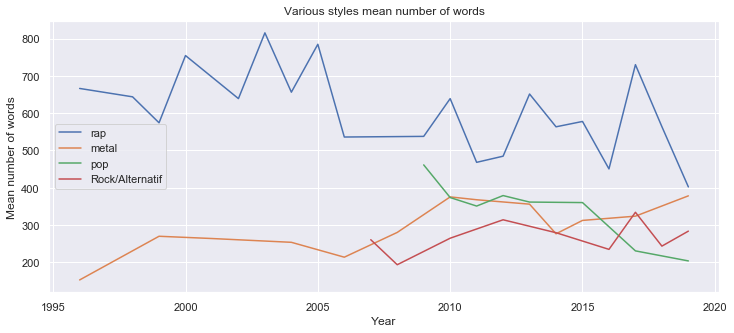

In [26]:
plt.figure(figsize=(12,5))
for style in df['Style'].unique():
    words_per_year = df[df['Style'] == style].groupby('Annee')['n_words'].mean()
    sns.lineplot(words_per_year.index, words_per_year.values, label=style)
plt.title('Various styles mean number of words')
plt.ylabel('Mean number of words')
plt.xlabel('Year')
plt.legend()
plt.show()

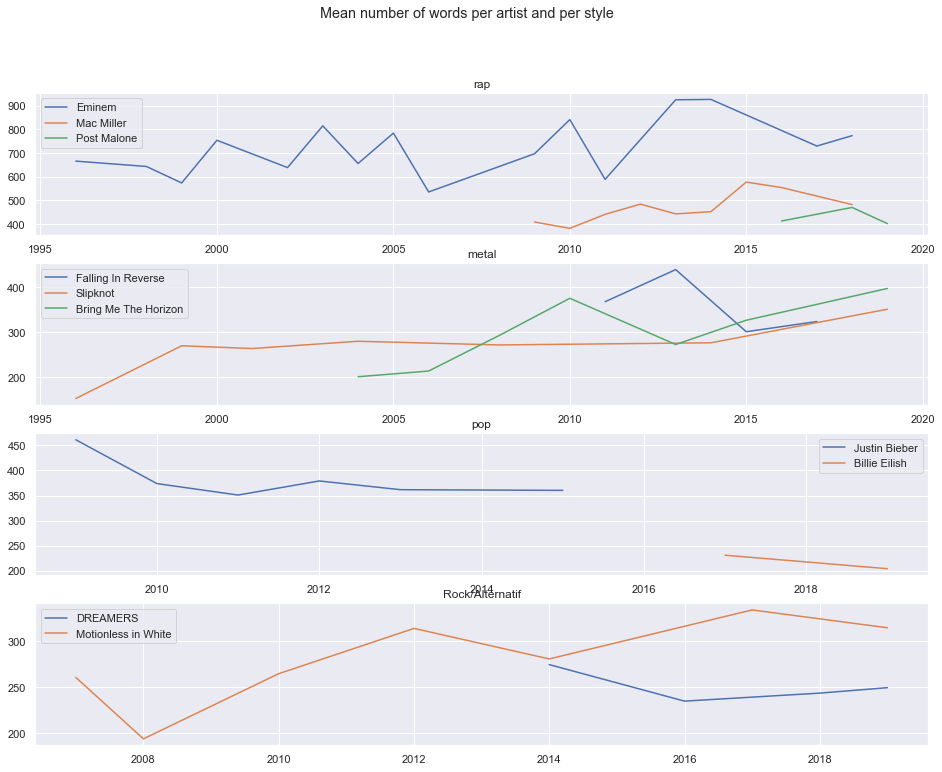

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(16, 12))
for (i, style) in enumerate(df['Style'].unique()):
    for artist in df.loc[df['Style'] == style, 'Artiste'].unique():
        words_per_year = df[df['Artiste'] == artist].groupby('Annee')['n_words'].mean()
        sns.lineplot(words_per_year.index, words_per_year.values, label=artist, ax=ax[i])
    ax[i].set_title(style)
    ax[i].set_xlabel('')
plt.suptitle('Mean number of words per artist and per style')
plt.legend()
plt.show()

As we can see, most of our music style have a homogeneous number of words around 300, except for the rap genre that is near double, around 600 words per music!

Thus, **rap music generally includes more words per song than other music styles**.

Nevertheless, **there is more heterogeneity in the rap style than in other styles**. For example, Eminem produces music with way more lyrics than Post Malone, even though they are both considered rappers.

We should now have a look at the diversity of these words.

### 1.2. Unique words
Now that we know the sizes of lyrics, let's have a look at their diversity!

In [28]:
df['n_unique_words'] = df['words'].apply(
    lambda word_list: len(set(word_list))
)

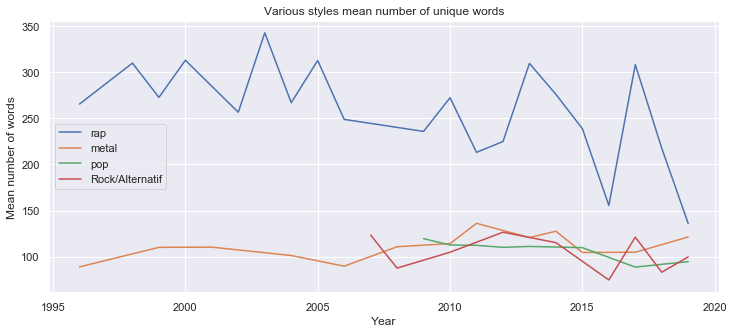

In [29]:
plt.figure(figsize=(12,5))
for style in df['Style'].unique():
    unique_words_per_year = df[df['Style'] == style].groupby('Annee')['n_unique_words'].mean()
    sns.lineplot(unique_words_per_year.index, unique_words_per_year.values, label=style)
plt.title('Various styles mean number of unique words')
plt.ylabel('Mean number of words')
plt.xlabel('Year')
plt.legend()
plt.show()

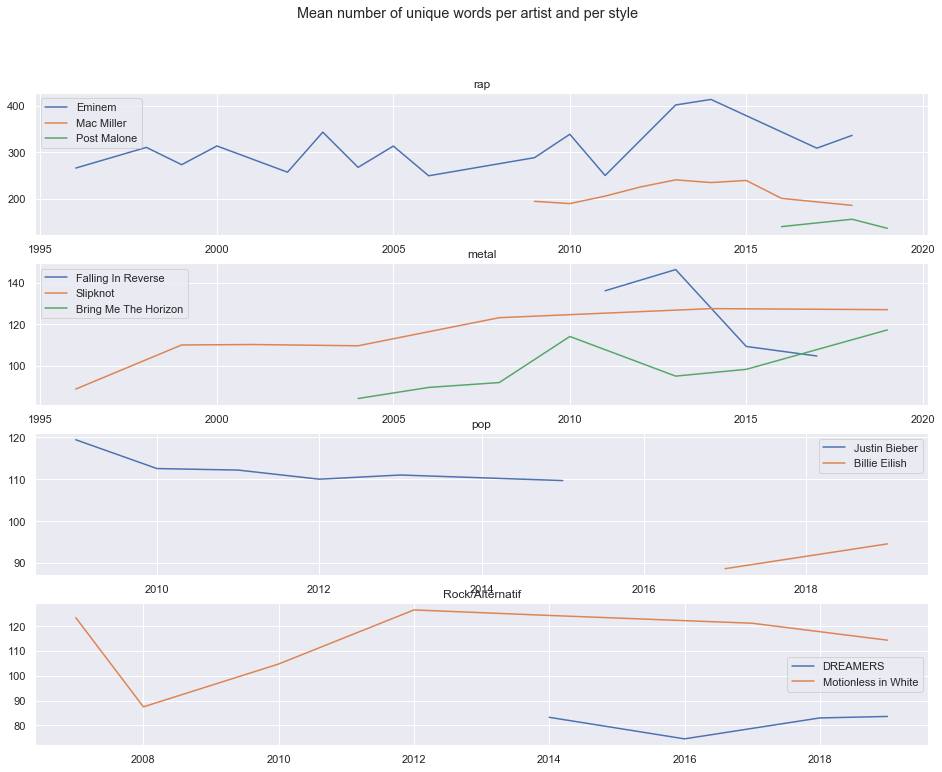

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(16, 12))
for (i, style) in enumerate(df['Style'].unique()):
    for artist in df.loc[df['Style'] == style, 'Artiste'].unique():
        unique_words_per_year = df[df['Artiste'] == artist].groupby('Annee')['n_unique_words'].mean()
        sns.lineplot(unique_words_per_year.index, unique_words_per_year.values, label=artist, ax=ax[i])
    ax[i].set_title(style)
    ax[i].set_xlabel('')
plt.suptitle('Mean number of unique words per artist and per style')
plt.legend()
plt.show()

We can see here that, once again, the rap style uses more diverse words than the other music styles. This is no surprise, since it also uses more words (even non-unique) per songs, so we are going to look at the uniqueness ratio of the songs.

In [31]:
df['unique_words_ratio'] = df['n_unique_words'] / df['n_words'] # Using highly optimized Numpy broadcasting

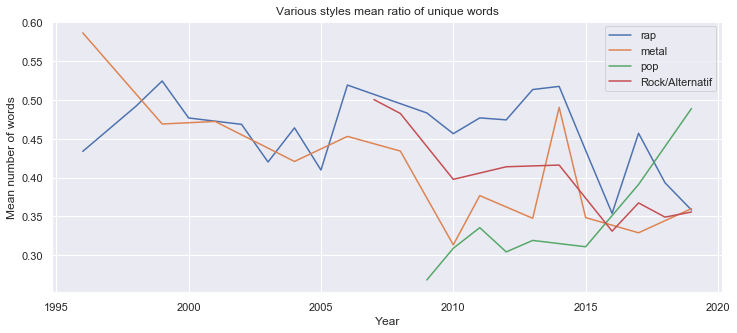

In [32]:
plt.figure(figsize=(12,5))
for style in df['Style'].unique():
    unique_words_per_year = df[df['Style'] == style].groupby('Annee')['unique_words_ratio'].mean()
    sns.lineplot(unique_words_per_year.index, unique_words_per_year.values, label=style)
plt.title('Various styles mean ratio of unique words')
plt.ylabel('Mean number of words')
plt.xlabel('Year')
plt.legend()
plt.show()

This graph is interesting! We can see two insights here:
- Even though rap produces a higher quantity of lyrics, **the ratio of unique words is not largely higher than other genres**.
- There are visible trends in the ratio of unique words:
 - **Metal diversity of vocabulary decline sinced 1995**.
 - **Pop diversity of vocabulary is rapidly increasing**.

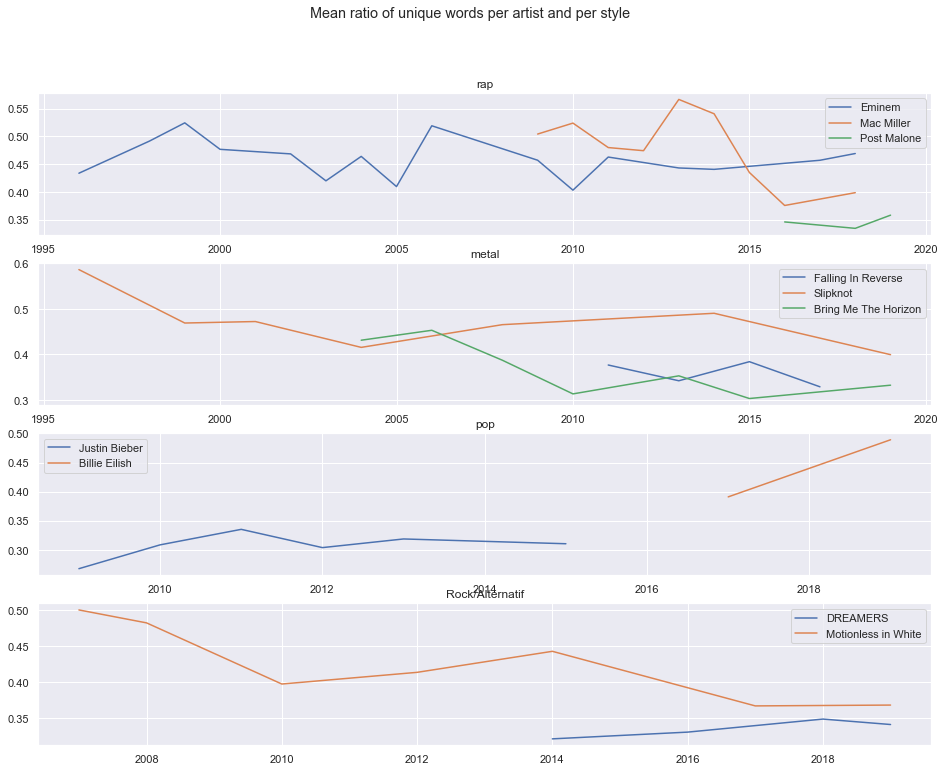

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(16, 12))
for (i, style) in enumerate(df['Style'].unique()):
    for artist in df.loc[df['Style'] == style, 'Artiste'].unique():
        unique_words_per_year = df[df['Artiste'] == artist].groupby('Annee')['unique_words_ratio'].mean()
        sns.lineplot(unique_words_per_year.index, unique_words_per_year.values, label=artist, ax=ax[i])
    ax[i].set_title(style)
    ax[i].set_xlabel('')
plt.suptitle('Mean ratio of unique words per artist and per style')
plt.legend()
plt.show()

As we can see, the rapid increase of ratio of unique words comes from Billie Eilish's work. Is this a general trend in the pop genre, or is this a specificity of our dataset? We would need more data to confirm this.

## 2. Which words?
Now that we have analyzed the quantities of words in the various lyrics of our dataset, we are going to have a qualitative approach, and understand which words are being used.

### 2.1. Most commonly used words
First, we are going to have a look at the most commonly used words. Nevertheless, we want to consider the various declinations of a word into one single word, not many. We are thus going to stem our words.

In [34]:
# Stemming the words before counting
stemmer = EnglishStemmer()
df['stem_words'] = df['words'].apply(
    lambda word_list: [stemmer.stem(word) for word in word_list] #TODO: optimize
)

In [35]:
# Counting the used words
all_words = pd.DataFrame({'word': [word for row in df['stem_words'] for word in row], 'count': 1})
all_words = all_words.groupby('word').sum()

C:\dev\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


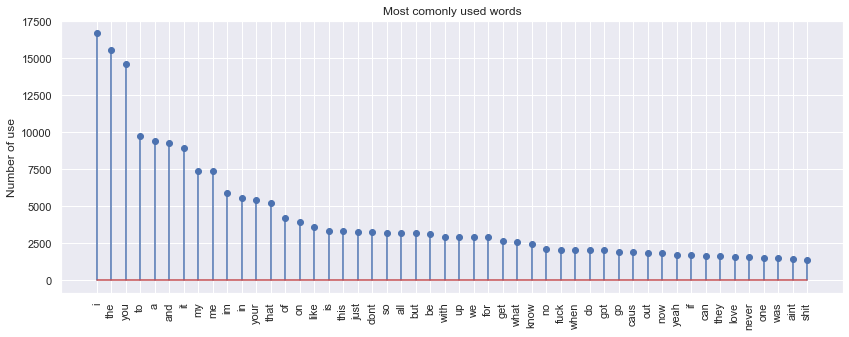

In [36]:
plt.figure(figsize=(14,5))
plt.stem(all_words.sort_values('count', ascending=False)[:50].index,
        all_words.sort_values('count', ascending=False)[:50])
plt.xticks(rotation=90)
plt.title('Most comonly used words')
plt.ylabel('Number of use')
plt.show()

C:\dev\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


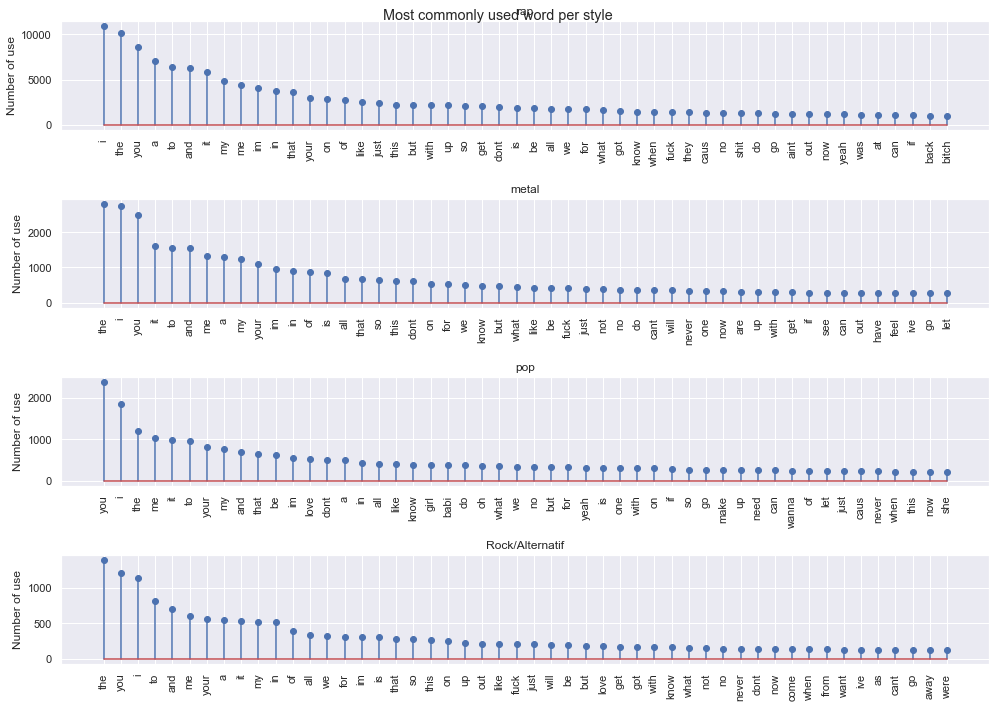

In [37]:
fig, ax = plt.subplots(4, 1, figsize=(14,10))
for (i, style) in enumerate(df['Style'].unique()):
    # Counting the used words
    all_words = pd.DataFrame({'word': [word for row in df.loc[df['Style']==style, 'stem_words'] for word in row], 'count': 1})
    all_words = all_words.groupby('word').sum()
    ax[i].stem(
        all_words.sort_values('count', ascending=False)[:50].index,
        all_words.sort_values('count', ascending=False)[:50]
    )
    ax[i].xaxis.set_tick_params(rotation=90)
    ax[i].set_title(style)
    ax[i].set_ylabel('Number of use')
plt.suptitle('Most commonly used word per style')
plt.tight_layout()
plt.show()

### 2.2. Vulgarity

We are now going to have a look at the vulgarity of the lyrics of our dataset.

In order to do so, we are going to use a [ban word list](https://www.freewebheaders.com/bad-words-list-and-page-moderation-words-list-for-facebook/) which is used for facebook moderation.

In [38]:
ban_words = pd.read_csv("data/ban_word.csv", header= None, names= ["nono"])
ban_words = ban_words.drop(index= 0).reset_index(drop= True)
ban_words = np.array(ban_words.values)
print(f'There are {len(ban_words)} banned words in our list.')

There are 1703 banned words in our list.


In [39]:
# Keep only the banned_words
df['banned_words'] = df['words'].apply(
    lambda word_array: word_array[np.isin(word_array, ban_words)]
)

In [40]:
df['n_banned_words'] = df['banned_words'].apply(len)

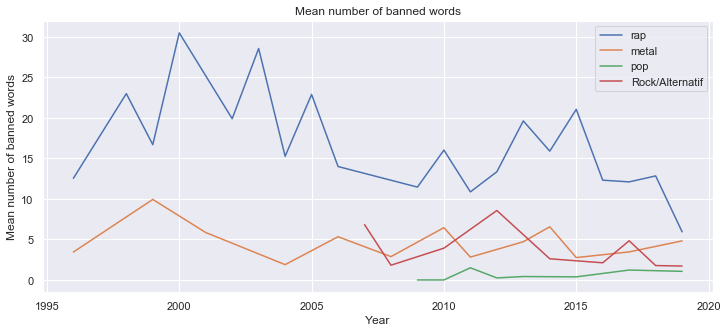

In [41]:
plt.figure(figsize=(12,5))
for style in df['Style'].unique():
    words_per_year = df[df['Style'] == style].groupby('Annee')['n_banned_words'].mean()
    sns.lineplot(words_per_year.index, words_per_year.values, label=style)
plt.title('Mean number of banned words')
plt.ylabel('Mean number of banned words')
plt.xlabel('Year')
plt.legend()
plt.show()

As we can see, the rap music style is, once again, the highest one on the charts, but this is caused by the cheer number of word in their songs. Let's have a look at the ratio!

In [42]:
df['banned_words_ratio'] = df['n_banned_words'] / df['n_words'] # Using highly optimized Numpy broadcasting

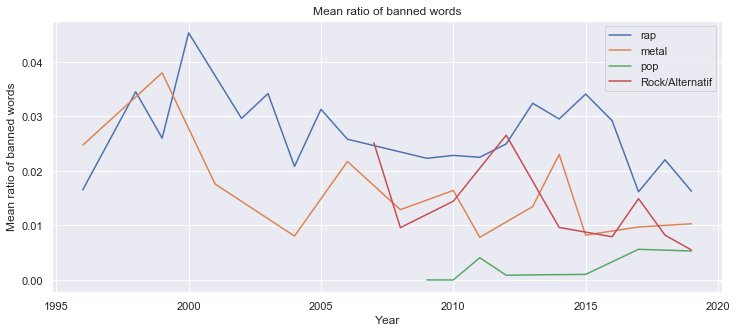

In [43]:
plt.figure(figsize=(12,5))
for style in df['Style'].unique():
    words_per_year = df[df['Style'] == style].groupby('Annee')['banned_words_ratio'].mean()
    sns.lineplot(words_per_year.index, words_per_year.values, label=style)
plt.title('Mean ratio of banned words')
plt.ylabel('Mean ratio of banned words')
plt.xlabel('Year')
plt.legend()
plt.show()

This graph allows us to draw some conclusions:
- **Rap style includes more banned words both proportionnaly and in general**.
- Many genres seem to be reducing their use of banned words through the years.
- The **pop music style uses really few banned words**. This might be because its target audience is wider.

### 2.3. Vocabulary style

We are now going to try and visualize the vocabulary used by the various lyrics we collected.

In [44]:
# Using the nnlm-en-dim128 TensorFlow embedding model available at
# https://tfhub.dev/google/nnlm-en-dim128/2
# The model is > 450MB, download might take a long time (25 minutes).
# Nevertheless, tensorflow hub caches the model, so the next uses are way faster (2 seconds).
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)

# Embedding of the Lyrics to a 128 dimensions dense tf.Tensor
embeddings = embed(df['Lyrics'].values)

In [45]:
# t-SNE 2 dimensional projection of the embeddings
projections = TSNE(n_components=2).fit_transform(embeddings)

Text(0.5, 1.0, 'Lyrics projection by style')

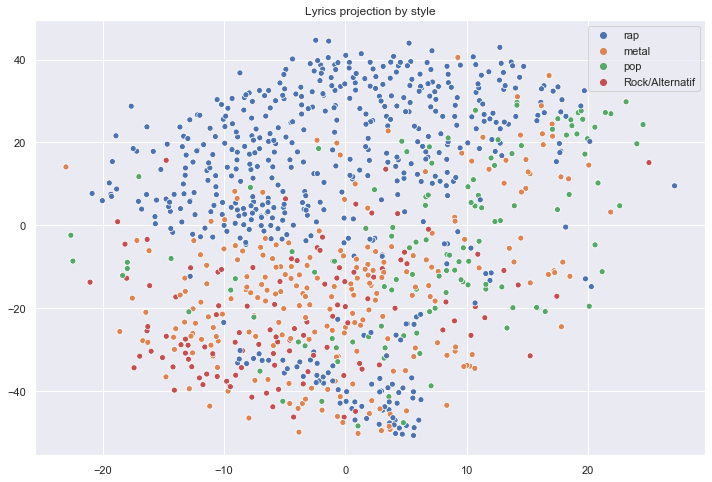

In [46]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=projections[:, 0], y=projections[:, 1], hue=df['Style'].values)
plt.title('Lyrics projection by style')

We can now visualize and interpret the projections of our lyrics.

As we can see, rap lyrics are definitely different than metal lyrics, it is easily visible. On the other hand, metal and rock/alternatif lyrics seem really similar. Finally, pop lyrics seem really diversified and do not visibly differ with other music styles.

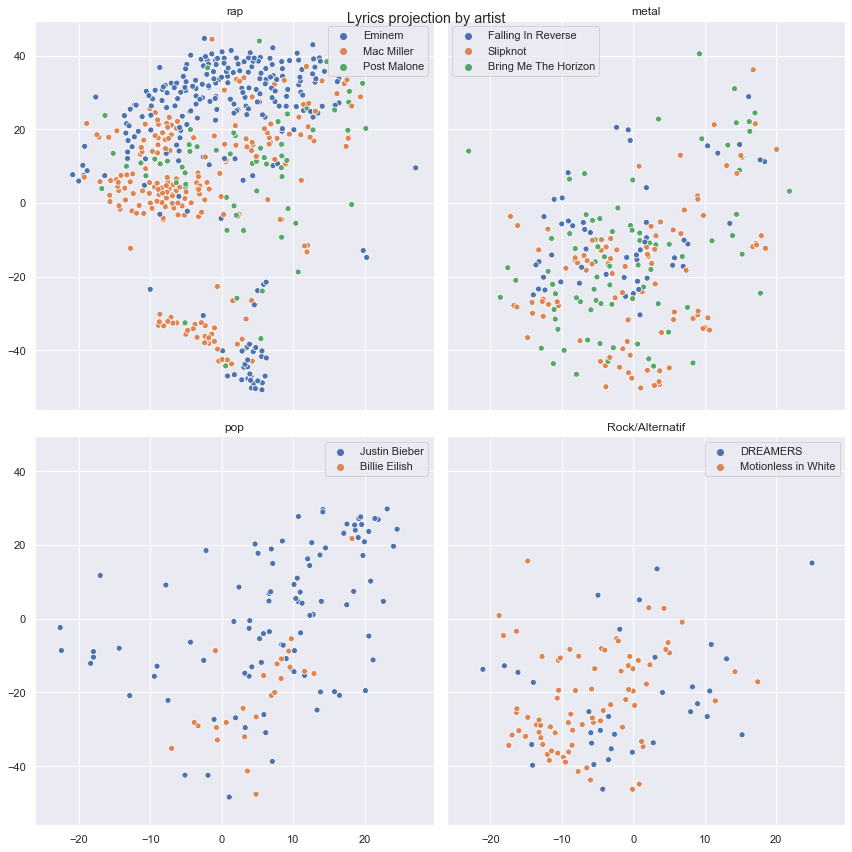

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex='all', sharey='all')
for (i, style) in enumerate(df['Style'].unique()):
    mask = df['Style'] == style
    sns.scatterplot(
        x=projections[mask, 0],
        y=projections[mask, 1],
        hue=df.loc[mask, 'Artiste'].values,
        ax=ax.flat[i]
    )
    ax.flat[i].set_title(style)
plt.suptitle('Lyrics projection by artist')
plt.tight_layout()
plt.show()

We can dig deeper and visualize artist by artist.

One good application would be to use this dataset to predict music style / artist when given a lyrics.

## 3. Supervised learning

### 3.1. Predict music style

We are now going to construct a model based on the embedder used earlier to try and predict the music style of our lyrics.

In [48]:
model = tf.keras.Sequential()
model.add(embed)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 124,644,820
Trainable params: 2,132
Non-trainable params: 124,642,688
_________________________________________________________________


In [49]:
X = df['Lyrics'].values
y = pd.get_dummies(df['Style']).values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
model.fit(X_train, y_train, epochs=100)

Train on 765 samples
Epoch 1/100
765/765 [==============================] - 1s 1ms/sample - loss: 1.1507 - accuracy: 0.5281 - AUC: 0.7556
Epoch 2/100
765/765 [==============================] - 0s 231us/sample - loss: 1.0582 - accuracy: 0.5451 - AUC: 0.7984
Epoch 3/100
765/765 [==============================] - 0s 241us/sample - loss: 0.9818 - accuracy: 0.5647 - AUC: 0.8344
Epoch 4/100
765/765 [==============================] - 0s 253us/sample - loss: 0.9276 - accuracy: 0.6026 - AUC: 0.8554
Epoch 5/100
765/765 [==============================] - 0s 247us/sample - loss: 0.8897 - accuracy: 0.6314 - AUC: 0.8695
Epoch 6/100
765/765 [==============================] - 0s 240us/sample - loss: 0.8539 - accuracy: 0.6588 - AUC: 0.8814
Epoch 7/100
765/765 [==============================] - 0s 253us/sample - loss: 0.8254 - accuracy: 0.6824 - AUC: 0.8934
Epoch 8/100
765/765 [==============================] - 0s 254us/sample - loss: 0.7880 - accuracy: 0.7059 - AUC: 0.9042
Epoch 9/100
765/765 [========

In [51]:
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=2)

255/255 - 0s - loss: 0.6734 - accuracy: 0.7725 - AUC: 0.9330


As we can see, our model which extends the nnlm model is capable, with a small dataset of only a thourand lyrics, of differencing several music styles.

It achieves an accuracy of 79% and a ROC AUC of 0.94!

### 3.2. Predict Artist

We are now going to try and predict the artist of a lyrics witht the same model.

In [52]:
# Construct the model
model = tf.keras.Sequential()
model.add(embed)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(len(df['Artiste'].unique()), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Prepare the dataset
X = df['Lyrics'].values
y = pd.get_dummies(df['Artiste']).values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Training
model.fit(X_train, y_train, epochs=100)

Train on 765 samples
Epoch 1/100
765/765 [==============================] - 1s 1ms/sample - loss: 2.2359 - accuracy: 0.1634 - AUC: 0.6277
Epoch 2/100
765/765 [==============================] - 0s 253us/sample - loss: 2.0559 - accuracy: 0.1817 - AUC: 0.7198
Epoch 3/100
765/765 [==============================] - 0s 263us/sample - loss: 1.9833 - accuracy: 0.2170 - AUC: 0.7446
Epoch 4/100
765/765 [==============================] - 0s 253us/sample - loss: 1.9222 - accuracy: 0.2654 - AUC: 0.7651
Epoch 5/100
765/765 [==============================] - 0s 264us/sample - loss: 1.8691 - accuracy: 0.3033 - AUC: 0.7831
Epoch 6/100
765/765 [==============================] - 0s 261us/sample - loss: 1.8190 - accuracy: 0.3216 - AUC: 0.7984
Epoch 7/100
765/765 [==============================] - 0s 275us/sample - loss: 1.7750 - accuracy: 0.3438 - AUC: 0.8107
Epoch 8/100
765/765 [==============================] - 0s 258us/sample - loss: 1.7343 - accuracy: 0.3830 - AUC: 0.8231
Epoch 9/100
765/765 [========

In [53]:
# Evaluating the results
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=2)

255/255 - 0s - loss: 1.0791 - accuracy: 0.6157 - AUC: 0.9323


Our model achieves good results here too, even though less good than on the music style prediction, which is probably easier to modelise.

**The next step to improve our models is to collect more data and restart the training.**